In [1]:
import pandas as pd
import numpy as np
import ast
import re
import nltk
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
import sklearn
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import Counter

C:\Users\LizaZ\miniconda3\envs\betterproj\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


# K-means clustering


Steps:
1. Preprocess skills
2. Turn skills into vectors using Word2Vec
3. Cluster the resulting vectors
4. Perform the data analyssi on the results

## 1. Preprocessing

In [2]:
df=pd.read_csv('merged_10k_skills.csv', index_col=0)
df.head(5)

Unnamed: 0.1                                              title  \
0             0         University Grad Software Engineer (Canada)   
1             1           Administration (1) - RPG AS400 Developer   
2             2          Senior Web Developer - Full Stack/Backend   
3             3  React + Ruby on Rails Developer - Remote - Canada   
4             4                       newSenior Back End Developer   

                             company  \
0                          Pinterest   
1  Zwilling J.A. Henckels Canada Ltd   
2                          WorkTango   
3                     FullStack Labs   
4                               BIMM   

                                         description   position  \
0  About Pinterest:  Millions of people across th...  developer   
1  About ZWILLING J.A. Henckels:  For over 285 ye...  developer   
2  WorkTango was founded as a passion-driven busi...  developer   
3  FullStack Labs is the fastest-growing software...  developer   
4  BIMM is booming, so we’re looking for a Senior...  developer   

                                         hard_skills  \
0                                   ['python', 'li']   
1  ['miyabi', 'rpg', '400 developer (contract pos...   
2                                      ['sequelize']   
3  ['uber', 'godaddy', 'mgm', 'siemens', 'stanfor...   
4   ['who', 'devops', 'node', 'js', 'commercecloud']   

                                          new_skills  
0       ['university grads', 'previous engineering']  
1  ['erp functions', 'rpg language', 'regard', 'i...  
2  ['senior backend', 'design team', 'designers',...  
3  ['fullstack team', 'professional experience', ...  
4  ['backend services', 'database schemas', 'best...

In [3]:
def flat_2d_arr(arr):
    flat=[]
    for small in arr:
        for element in small:
            flat.append(element)
    return flat

In [4]:
all_skills=[ast.literal_eval(x) for x in df['new_skills']]
temp=[ast.literal_eval(x) for x in df['hard_skills']]
print(temp)
for skill_arr in temp:
        all_skills.append(skill_arr)
all_skills=flat_2d_arr(all_skills)

[['python', 'li'], ['miyabi', 'rpg', '400 developer (contract position', 'ibm iseries', 'time management  creative and innovative', 'dependability  research and analysis  operating equipment  ethics', 'integrity', 'edi', 'r', 'a', 'implementing new', 'ftp', 'rpg', 'pos', 'documenting', 'db2', 'tcp', 'ip', 'ibm', 'ipl', 'sap', 'tm1', 'human resources'], ['sequelize'], ['uber', 'godaddy', 'mgm', 'siemens', 'stanford university', 'glassdoor', 'react and ruby on rails', 'agile', 'scrum', 'covid', 'classes'], ['who', 'devops', 'node', 'js', 'commercecloud'], ['great team', 'banking', 'capital markets', 'finance risk', 'compliance', 'insurance', 'wealth and investment management', 'digital delivery', 'java', 'ci', 'development', 'java restful', 'devops', 'java development'], ['requirementsyou', 'saas'], ['app', 'ssl pinning', 'app universal linking', 'secure key chain for ios', 'ios app store', 'machine learning', 'artificial intelligence'], ['restful apiswork', 'ux', 'ui designers', 'javasc

In [5]:
def wordarr_prep(wa):
    final=[]
    for word in wa:
        temp=word.lower()
        temp=re.sub(r"[^a-z ]"," ", temp)
        temp=re.sub(r"\s{2,}", " ", temp)
        if temp!=' ':
            final.append(temp.strip())
    return final
    

In [6]:
def word_arr_2d_prep(wa2):
    final=[]
    for d in wa2:
        final.append(wordarr_prep(d))
    return final

In [7]:
all_descr=[word_tokenize(x) for x in df['description']]

In [8]:
descr=word_arr_2d_prep(all_descr)

In [9]:
skills_tok=[word_tokenize(x) for x in all_skills]
skills_ready=word_arr_2d_prep(skills_tok)

## Word2Vec model
The training and usage of the word2Vec model is built on [this tutorial](https://www.kaggle.com/pierremegret/gensim-word2vec-tutorial) . The skill vectorization method is taken from [this tutorial](https://ai.intelligentonlinetools.com/ml/text-clustering-word-embedding-machine-learning/)

### train the model

In [10]:
def train_model(words):
    model = Word2Vec(min_count=1)
    model.build_vocab(words)
    model.train(words, total_examples=model.corpus_count, epochs=10)
    return model

In [11]:
model=train_model(descr)

### Test-cases

#### Technical skills

In [12]:
model.wv.most_similar(positive=["javascript"])

[('css', 0.672817587852478),
 ('php', 0.6716058254241943),
 ('bootstrap', 0.664953351020813),
 ('node js', 0.6602277159690857),
 ('nodejs', 0.6573543548583984),
 ('html', 0.6560664176940918),
 ('typescript', 0.6478546261787415),
 ('js', 0.6380493640899658),
 ('angular', 0.6285330653190613),
 ('angularjs', 0.6210992932319641)]

In [52]:
model.wv.most_similar(positive=["python"])

[('node js', 0.6581574082374573),
 ('scala', 0.6411610841751099),
 ('rails', 0.6155632734298706),
 ('bash', 0.6121390461921692),
 ('perl', 0.6121126413345337),
 ('django', 0.611086905002594),
 ('nodejs', 0.6052659749984741),
 ('tensorflow', 0.6046777367591858),
 ('spark', 0.6021783947944641),
 ('node', 0.60038822889328)]

#### Soft skills

In [13]:
model.wv.most_similar(positive=["communications"])

[('relations', 0.5351693034172058),
 ('communication', 0.5313989520072937),
 ('presentations', 0.4940185546875),
 ('facilitation', 0.48180559277534485),
 ('outreach', 0.4598565399646759),
 ('presentation', 0.43737101554870605),
 ('d panneurs', 0.42574772238731384),
 ('marketing', 0.42550092935562134),
 ('tactics', 0.42424067854881287),
 ('mat riel', 0.41571056842803955)]

In [14]:
model.wv.most_similar(positive=["writing"])

[('developing', 0.496782511472702),
 ('write', 0.49584662914276123),
 ('documenting', 0.4936234951019287),
 ('defining', 0.4911762773990631),
 ('user friendly', 0.4815652370452881),
 ('troubleshooting', 0.48057541251182556),
 ('maintainable', 0.478794127702713),
 ('written', 0.4738450348377228),
 ('implementing', 0.47140082716941833),
 ('sass scss', 0.4680269658565521)]

In [15]:
model.wv.most_similar(positive=["cooperation"])

[('teamwork', 0.4781261086463928),
 ('cracks calm', 0.46813061833381653),
 ('ideas opinions', 0.46611127257347107),
 ('camaraderie', 0.4636656939983368),
 ('dialogue', 0.4605616629123688),
 ('environment having', 0.45916032791137695),
 ('tact', 0.4444732069969177),
 ('workplace requirementsmust', 0.44377297163009644),
 ('management fosters', 0.4433633089065552),
 ('collaboration', 0.4396916627883911)]

In [16]:
model.wv.most_similar(positive=["reliability"])

[('scalability', 0.5686424970626831),
 ('uptime', 0.5306066870689392),
 ('maintainability', 0.4958702623844147),
 ('efficiency', 0.48337486386299133),
 ('clearance', 0.4778550863265991),
 ('constructability', 0.4574945867061615),
 ('manufacturability', 0.4563165307044983),
 ('environmentdemonstrated', 0.45022082328796387),
 ('devops site', 0.42979636788368225),
 ('wilson', 0.42952537536621094)]

Thus, we can see that the model is better at identifying technical skills. This is explained by the fact that our technical skills extraction was more refined and returned more reliable results. However, for some soft-skills the model can also identify similar skills, so we consider it good enough for clustering

### Vectorize compound skills
A lot of our skills consist of more than 1 word, so we will vectorize each word in the skill and take the average

In [18]:
def skill_vectorizer(skill):
    skill_vec =[]
    numw = 0
    for w in skill:
        try:
            if numw == 0:
                skill_vec = model.wv[w]
            else:
                skill_vec = np.add(skill_vec, model.wv[w])
            numw+=1
        except:
            pass
     
    return np.asarray(skill_vec) / numw

In [19]:
skill_vectors=[skill_vectorizer(x) for x in skills_ready]

In [20]:
skill_vectors

[array([-1.0984536 ,  0.33347452, -1.3203481 ,  0.18300998, -2.7596667 ,
         0.15346734,  0.06400573,  1.0757679 ,  0.7108863 , -0.17589366,
         0.58305156, -0.22350533, -1.2316333 ,  2.8432217 , -0.56420064,
        -2.405029  , -2.093524  ,  0.61422753,  0.93619764, -1.8018223 ,
        -0.8417484 ,  0.2899825 , -0.7094013 , -0.6156016 , -0.2992271 ,
        -1.5510232 ,  1.5098743 , -2.0745976 ,  0.58938426, -0.753002  ,
         0.89325166, -1.7946651 , -0.31181633,  0.4560585 , -1.2782813 ,
         0.13214977, -0.44808716,  2.603539  , -2.9060116 ,  1.1933318 ,
        -0.39279372,  0.8988267 , -2.4721894 ,  2.2566383 ,  0.49875456,
        -0.6238073 , -0.21158543, -3.5247207 , -0.5166936 , -1.5537624 ,
         1.3310082 , -0.8318571 ,  0.05993012,  2.3790774 , -0.00740755,
        -1.2133944 , -0.01936036, -0.52356195,  1.1927483 , -0.14975739,
         2.41319   ,  0.1416607 , -1.5941801 ,  0.6078546 ,  0.762071  ,
        -0.7740451 ,  0.78345776,  2.0048487 ,  0.8

In [21]:
fsv=[]
fsn=[]
for i in range (0, len(skill_vectors)):
    if len(skill_vectors[i])==100:
        fsv.append(skill_vectors[i])
        fsn.append(skills_ready[i])

## Clustering

### Choose the appropriate number of clusters using the elbow method
We implemented the elbow method using [this tutorial](https://www.analyticsvidhya.com/blog/2021/04/k-means-clustering-simplified-in-python/)

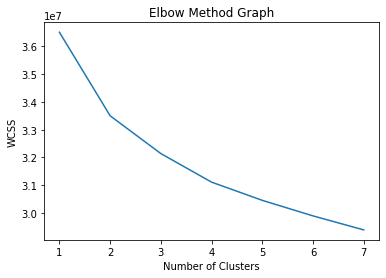

In [22]:
wcss = []
for i in range(1,8):
    kmeans = KMeans(i)
    kmeans.fit(fsv)
    wcss_iter = kmeans.inertia_
    wcss.append(wcss_iter)

numClusters = range(1,8)
plt.plot(numClusters, wcss)
plt.title('Elbow Method Graph')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

The graph changes it slope radically at number of clusters=2 so, we will choose 2 clusters

In [23]:
kmeans=KMeans(2)
kmeans.fit(fsv)

KMeans(n_clusters=2)

In [24]:
clust_df=pd.DataFrame([' '.join(x) for x in fsn], columns=['skill'])
clust_df['cluster']=kmeans.labels_

In [25]:
clust_df

skill  cluster
0                    university grads        1
1                previous engineering        1
2                       erp functions        1
3                        rpg language        0
4                              regard        1
...                               ...      ...
179967                        terrace        1
179968                 long term care        1
179969                      community        1
179970                        society        1
179971  contract furniture management        1

[179972 rows x 2 columns]

## Data analysis

In [26]:
def calc_occ(arr):
    cnt=Counter()
    for word in arr:
        cnt[word]+=1
    return cnt

In [27]:
def gen_wordCloud(arr):
    wordcloud = WordCloud(colormap='plasma', background_color='white', width=900, height=400).generate_from_frequencies(calc_occ(arr))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    return wordcloud

### Most popular skills for the whole dataset

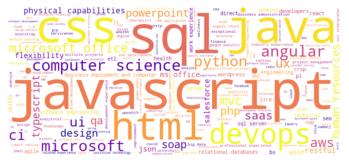

In [48]:
gen_wordCloud(all_skills)

### Most popular skills in cluster one

In [28]:
s1=[x[0] for x in np.array(clust_df[clust_df['cluster']==0])]

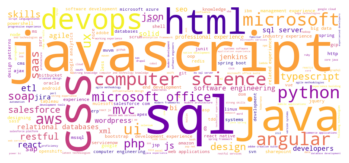

In [29]:
gen_wordCloud(s1)

### Most popular skills in cluster two

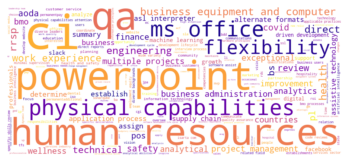

In [31]:
s2=[x[0] for x in np.array(clust_df[clust_df['cluster']==1])]
gen_wordCloud(s2)

We can roughly label the first cluster "programming cluster" because it contains mostly technical, programming related skills, and label the second cluster "managerial" cluster because it contains mostly skills related to business and useful in management. We can also see certain division on hard and soft skills, with the 1st cluster containing almost exclusively technical skills. Thus, we could also label clusters "hard" and "soft" but that would be less accurate because the second cluster contains a mix of hard and soft skills. 

### Most popular skills for developer

In [32]:
dev_df=df[df['position']=='developer']

In [33]:
dev_skills=[ast.literal_eval(x) for x in dev_df['new_skills']]
temp=[ast.literal_eval(x) for x in dev_df['hard_skills']]
for skill_arr in temp:
        dev_skills.append(skill_arr)
dev_skills=flat_2d_arr(dev_skills)

In [34]:
dev_tok=[word_tokenize(x) for x in dev_skills]
ds_b=word_arr_2d_prep(dev_tok)
dev_final=[' '.join(x) for x in ds_b]

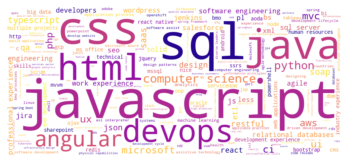

In [35]:
gen_wordCloud(dev_final)

In [36]:
calc_occ(dev_final).most_common()

[('javascript', 1594),
 ('sql', 1390),
 ('css', 1160),
 ('java', 1098),
 ('html', 833),
 ('devops', 613),
 ('angular', 605),
 ('computer science', 595),
 ('python', 521),
 ('ui', 430),
 ('aws', 425),
 ('ci', 416),
 ('mvc', 403),
 ('ux', 400),
 ('microsoft', 377),
 ('php', 343),
 ('typescript', 309),
 ('soap', 284),
 ('saas', 279),
 ('qa', 242),
 ('restful', 241),
 ('json', 233),
 ('design', 231),
 ('js', 207),
 ('etl', 205),
 ('react', 204),
 ('sql server', 187),
 ('software engineering', 174),
 ('wordpress', 167),
 ('relational databases', 160),
 ('xml', 155),
 ('jenkins', 152),
 ('agile', 147),
 ('jira', 147),
 ('engineering', 146),
 ('pl', 145),
 ('seo', 145),
 ('salesforce', 144),
 ('developers', 141),
 ('bs', 141),
 ('solid', 139),
 ('work experience', 138),
 ('less', 138),
 ('professional experience', 137),
 ('development experience', 137),
 ('bootstrap', 135),
 ('c', 131),
 ('gcp', 131),
 ('powershell', 131),
 ('bi', 131),
 ('http', 130),
 ('human resources', 128),
 ('mssql', 12

Thus, the more technical, technology-based skills are required from the developer. These results make logical sense and prove that we were able to correctly retrieve skills.

### Most popular skills for manager

In [37]:
man_df=df[df['position']=='manager']
man_skills=[ast.literal_eval(x) for x in man_df['new_skills']]
temp=[ast.literal_eval(x) for x in man_df['hard_skills']]
for skill_arr in temp:
        man_skills.append(skill_arr)
man_skills=flat_2d_arr(man_skills)
man_tok=[word_tokenize(x) for x in man_skills]
ms_b=word_arr_2d_prep(man_tok)
man_final=[' '.join(x) for x in ms_b]

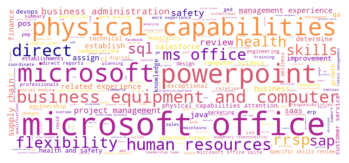

In [38]:
gen_wordCloud(man_final)

In [39]:
calc_occ(man_final).most_common()

[('microsoft office', 385),
 ('powerpoint', 253),
 ('microsoft', 245),
 ('physical capabilities', 226),
 ('business equipment and computer', 220),
 ('direct', 201),
 ('human resources', 194),
 ('ms office', 174),
 ('flexibility', 168),
 ('rrsp', 166),
 ('sql', 150),
 ('skills', 149),
 ('sap', 146),
 ('health', 138),
 ('business administration', 137),
 ('review', 133),
 ('safety', 130),
 ('project management', 108),
 ('supply chain', 107),
 ('management experience', 106),
 ('finance', 106),
 ('assign', 106),
 ('saas', 104),
 ('business', 103),
 ('related experience', 99),
 ('pos', 99),
 ('salesforce', 97),
 ('establish', 93),
 ('java', 93),
 ('improvement', 91),
 ('determine', 85),
 ('qa', 83),
 ('health and safety', 83),
 ('growth', 82),
 ('technical', 81),
 ('customer service', 81),
 ('ci', 80),
 ('computer science', 80),
 ('physical capabilities attention', 79),
 ('knowledge', 79),
 ('devops', 79),
 ('exceptional', 78),
 ('partnership', 77),
 ('hospitality', 77),
 ('design', 76),
 ('

A lot of technical skills are also required from the manager, however, skills do not include typical programming software. The set of skills also includes less program-based skills such as project management and business administration

### Intersection between 2 sets of skills

In [40]:
inter=[x for x in set(man_final).intersection(set(dev_final)) if x!='']

In [41]:
inter=set([x for x in set(man_final).intersection(set(dev_final)) if x!=''])

In [42]:
def comp_occ(arr1, arr2, inter):
    occ1=calc_occ(arr1)
    occ2=calc_occ(arr2)
    final={}
    for word in inter:
        final[word]=occ1[word]+occ2[word]
    return final
        

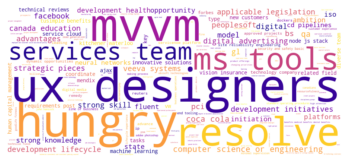

In [43]:
mo=comp_occ(man_final, dev_final, inter)
gen_wordCloud(mo)

The two sets intersect mostly at the most basic skills. This shows that technology knwodledge and experience is important in both spheres. Some soft skills such as an abilitiy to come up with innovative solutions are also required

In [44]:
len(set(man_final))

12405

In [45]:
len(set(dev_final))

11165

In [46]:
len(inter)

2390

As we can see the intersection is not extremely big, but it is significant. Thus, technological knowledge as well as certain amount of soft skills is required for both jobs. However the specific requirements vary.